In [217]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
from plotly.plotly import plot_mpl

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from pmdarima.arima import auto_arima

from code4th.datasources import Air4Thai

In [218]:
# Apart of the given command, you might need to include other packages imported above as well.

# !pip install code4th-datasource-air4thai statsmodels

# Introduction

This notebook is meant to:
1) demonstate how to use `Air4Thai` to get air quality measurements from http://air4thai.pcd.go.th. 
2) provide some simple time series analysis (seasonal decomposing and forecasting models).

If you have questions or comments regarding the content, please create a issue on [Github][issue-page]. 

[issue-page]: https://github.com/codeforthailand/datasource-air4thai/issues

In [17]:
df = Air4Thai.fetch(
    stations=['59t'], # สถานีจุดวัด กรมประชาสัมพันธ์
    measurements=['PM25'],
    sdate='2019-01-01', edate='2019-02-03')

len(df)

816

In [39]:
df[:26]

,stationID,DATETIMEDATA,PM25
0,59t,2019-01-01 00:00:00,19.0
1,59t,2019-01-01 01:00:00,24.0
2,59t,2019-01-01 02:00:00,31.0
3,59t,2019-01-01 03:00:00,34.0
4,59t,2019-01-01 04:00:00,31.0
5,59t,2019-01-01 05:00:00,30.0
6,59t,2019-01-01 06:00:00,35.0
7,59t,2019-01-01 07:00:00,26.0
8,59t,2019-01-01 08:00:00,14.0
9,59t,2019-01-01 09:00:00,14.0


# Data Preparation

In [215]:
# remove rows containing null values (this happens from the source, we can't really do anything here!)
df2 = df[~df['PM25'].isna()]
len(df), len(df2)

(816, 814)

In [216]:
df2.index = df2['DATETIMEDATA'] # this is required by following tasks. 
len(df2)

814

# Seasonal Analysis
The purpose of this analysis is to how our data actually looks like. For example, there is some kinds of (seasonal) trends in the data.

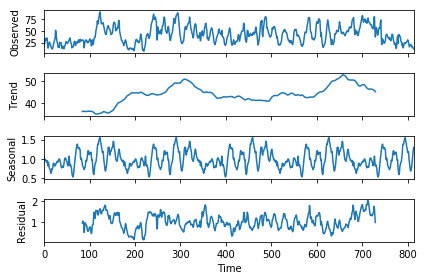

In [69]:
freq = 24*7 # datapoint is collected every hour
result = seasonal_decompose(df2['PM25'].values, model='multiplicative', freq=freq)
result.plot();

For the plot above, we can see that the averaged trend increases gradually. 

# Buiding time series models

In the following, we're going to train a [AutoRegressive Integrated Moving Average (ARIMA)][arima] to predict/forecast PM2.5 values for the next `x` days.

[arima]: https://people.duke.edu/~rnau/411arim.htm

We will start with training a model from training data, using January data (2019-01). We'll use it to predict the values of 2019-02-01 to 2019-02-03. 

## Predicting history data

In [ ]:
# Note: this is a crude way to split the data.
# TODO: find a more neat way to do so.

train, test = df2[:(-24*3)], df2[(-24*3):]
train.shape, test.shape

In [177]:
model1 = sm.tsa.ARIMA(train['PM25'], order=(1, 0, 13))
model1_fit = model.fit(trend='c', disp=0)

/Users/heytitle/projects/venv-python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [202]:
next_predictions = 3*24
y_hat = model1_fit.predict(start=train.shape[0], end=train.shape[0] + next_predictions - 1)

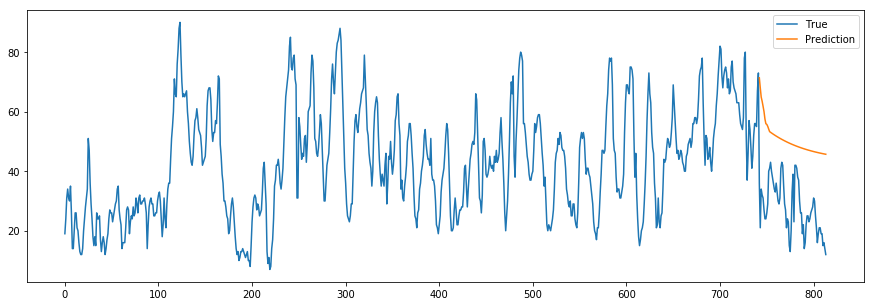

In [208]:
x = train.shape[0] + np.array(range(next_predictions))
plt.figure(figsize=(15, 5))
plt.plot(range(len(df2['PM25'])), df2['PM25'], label='True')
plt.plot(x, y_hat, label='Prediction')
plt.legend()

In [212]:
'MSE %f' % mean_squared_error(test['PM25'].values, y_hat)

'MSE 584.036058'

The plot and the MSE above don't look good. Probably, we need to find better hyperparameters.

## Forecasting model
In the following, we're going to train an ARIMA model from the whole dataste, and forecast PM2.5 values for the next `3` days. 

/Users/heytitle/projects/venv-python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                              ARMA Model Results                              
Dep. Variable:                   PM25   No. Observations:                  814
Model:                    ARMA(1, 13)   Log Likelihood               -2550.447
Method:                       css-mle   S.D. of innovations              5.543
Date:                Mon, 04 Feb 2019   AIC                           5132.894
Time:                        02:11:05   BIC                           5208.125
Sample:                             0   HQIC                          5161.770
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          40.2715      3.967     10.151      0.000      32.495      48.047
ar.L1.PM25      0.9750      0.015     66.000      0.000       0.946       1.004
ma.L1.PM25      0.3451      0.038      9.058    

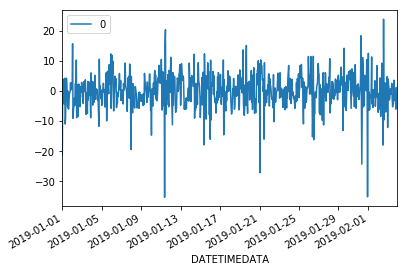

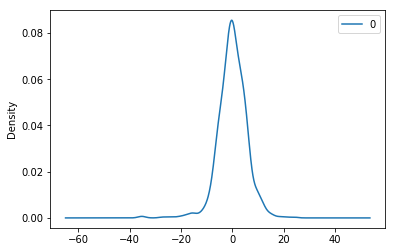

                0
count  814.000000
mean     0.034366
std      5.592817
min    -35.344315
25%     -2.826409
50%      0.030847
75%      3.360627
max     23.902920


In [158]:
model = sm.tsa.ARIMA(df2['PM25'], order=(1, 0, 13))
model_fit = model.fit(trend='c', disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')

plt.show()
print(residuals.describe())

In [213]:
y,  std, _ = model_fit.forecast(steps=3*24) # forecast for the next 3 days

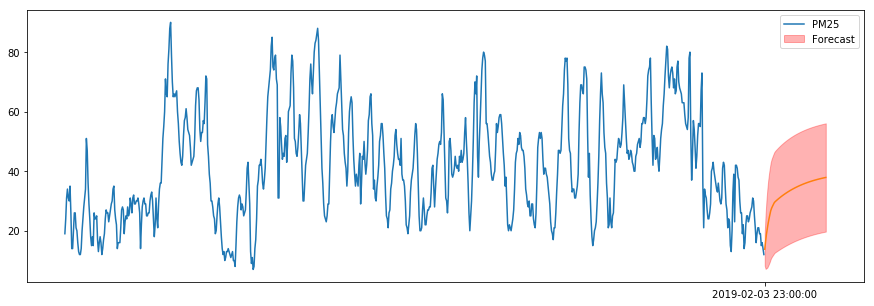

In [214]:

total_data = len(df2)

predicting_x = np.array(range(forecast_y.shape[0])) + total_data

plt.figure(figsize=(15, 5))

plt.plot(range(total_data), df2['PM25']) 

plt.xticks([total_data], [str(df2.index[-1])])
plt.plot(predicting_x, y)

plt.fill_between(predicting_x, y - std, y + std, color='r', alpha=0.3, label='Forecast')
plt.legend()